<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Computação em Nuvem II
Caderno de **Exercícios**<br>
Professor [André Perez](https://www.linkedin.com/in/andremarcosperez/)

---

# **Tópicos**

<ol type="1">
  <li>AWS Lambda;</li>
  <li>AWS Step Functions;</li>
  <li>AWS EventBridge.</li>
</ol>

---

# **Exercícios**

## 1\. AWS Lambda

Replique as atividades do item 1.3 em sua conta.


**Objetivo:Extrair dados da site da BCB através de uma API:**

**Passos:**

**No S3 AWS:**

*  Criar um bucket no AWS S3 para salvar o dado original (bronze);
*  Criar um bucket no AWS S3 para salvar o dado transformado (silver);


**No Lambda AWS:**

* Criar uma função AWS Lambda para extrair o dado original;   
* Criar uma função AWS Lambda para transformar o dado original;
* Criar uma função AWS Lambda para criar uma tabela no AWS Athena apontando para o bucket do dado transformado.  



# **1-Criar um bucket no AWS S3 para salvar o dado original (bronze)e (Silver)**

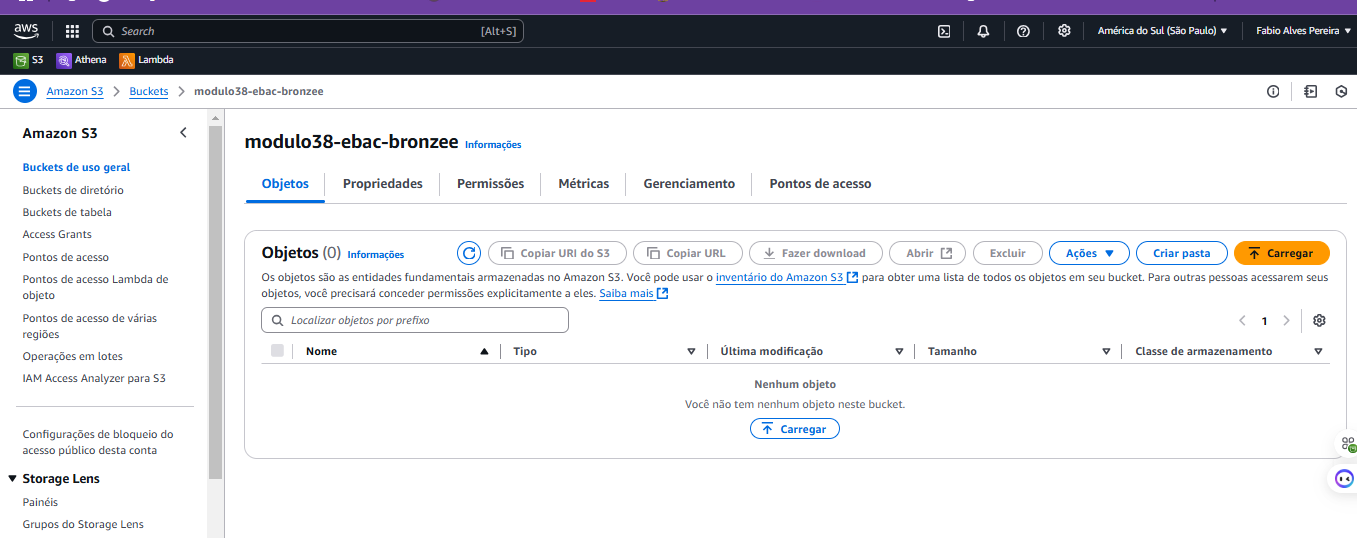

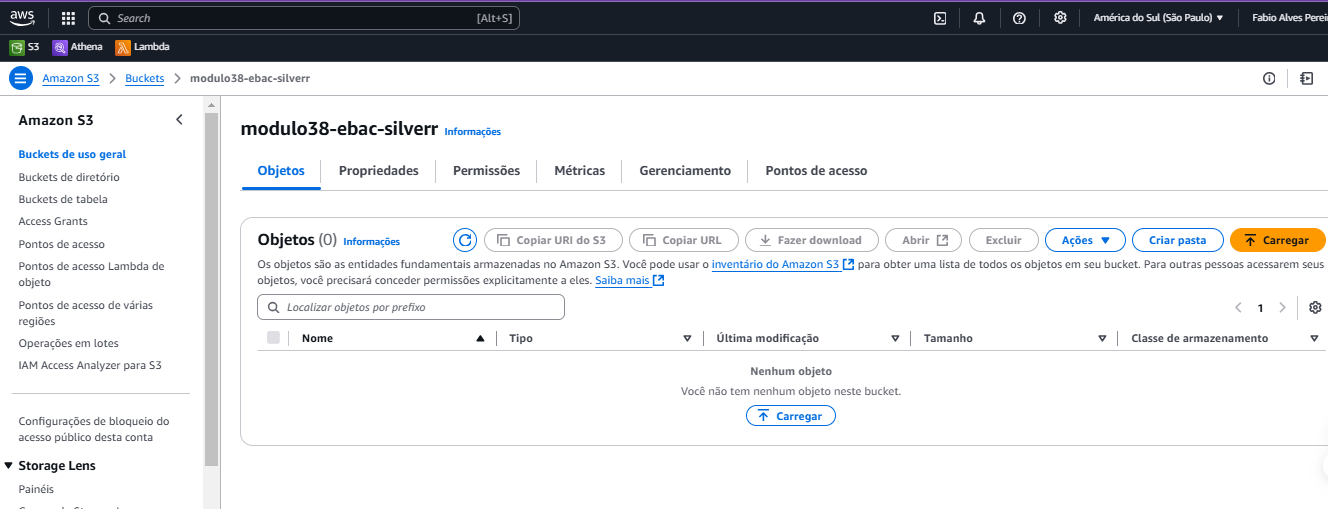

**Parte 2:**

1-Criar uma função AWS Lambda para extrair o dado original e armazenar no s3 bucket bronzee; **

2-Criar função lambda **para fazer o armazenamento do dado transformado no s3 bucket silverr

3-Criar uma função AWS Lambda para criar uma tabela no AWS Athena apontando para o bucket do dado transformado no caso no S3 bucket Silverr.

 Ao criar a função **modulo38-ebac-bronzee** depois foi definida **a linguagem no caso python** em seguida   a politica de permissões >**s3 AcessFull** e por fim foi **adicionado em  código da função** o código de extração.

 Um Processo  semelhante acontecerá ao criar a segunda função **modulo38-ebac-silverr** porém o código inserido ** terá o objetivo de transformar os dados e transferí-los** para o s3 **bucket modulo38-ebac-silverr**.

  A função AWS Lambda **modulo38-ebac-athenaa-results** cria uma tabela no AWS Athena apontando para o bucket do dado transformado no caso no S3 bucket Silverr.

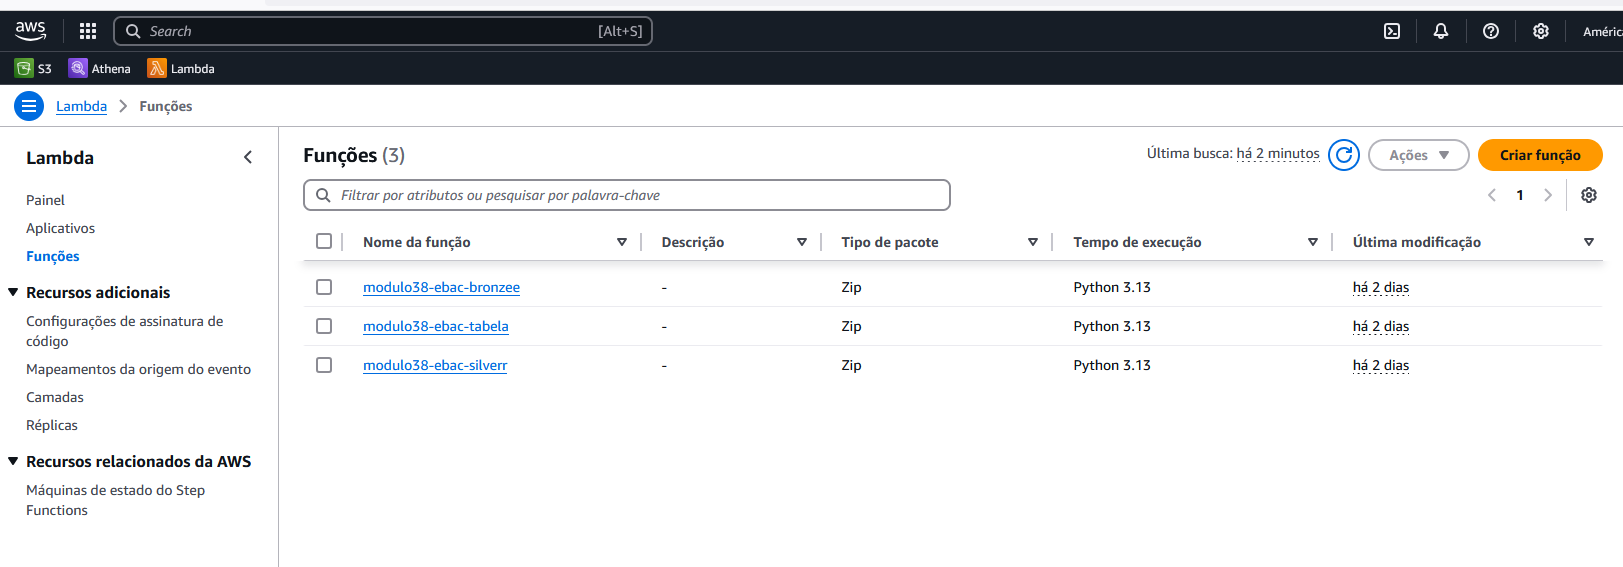

**Parte 3:**

**No AWS Lambda  Inserir em Funções, >código< o código a seguir para atender bucket bronze:**

Código AWS [Lambda](https://aws.amazon.com/pt/lambda/) para *bucket* **Bronze**:

---


In [ ]:
#Criar uma função AWS Lambda para extrair o dado original s3 bronzee;
import json
import logging
from datetime import datetime

import boto3
import urllib3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  URL = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.4392/dados?formato=json'
  BRONZE_BUCKET = 'modulo38-ebac-bronzee'

  client = boto3.client('s3')

  date = datetime.now().strftime('%Y-%m-%d')
  filename_json = f'stock-exchange-{date}.json'

  # -- extract

  try:
    http = urllib3.PoolManager()
    response = http.request(url=URL, method='get')
  except Exception as exc:
    raise exc
  else:
    data = json.loads(response.data.decode())
    logging.info(msg=data)

  # -- transform

  ...

  # -- load

  try:
      with open(f'/tmp/{filename_json}', mode='w', encoding='utf8') as fp:
          json.dump(data, fp)
      client.upload_file(Filename=f'/tmp/{filename_json}', Bucket=BRONZE_BUCKET, Key=filename_json)
  except ClientError as exc:
      raise exc

  return json.dumps(dict(status=True))

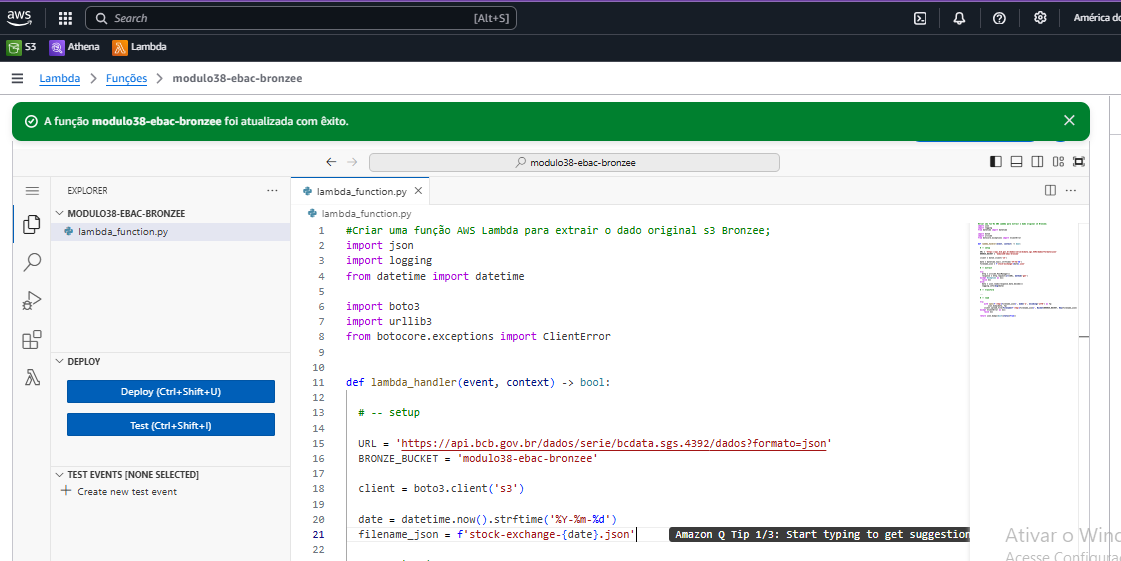

**Parte 4: Verificando Permissões para s3 bucket armazenar extração:**





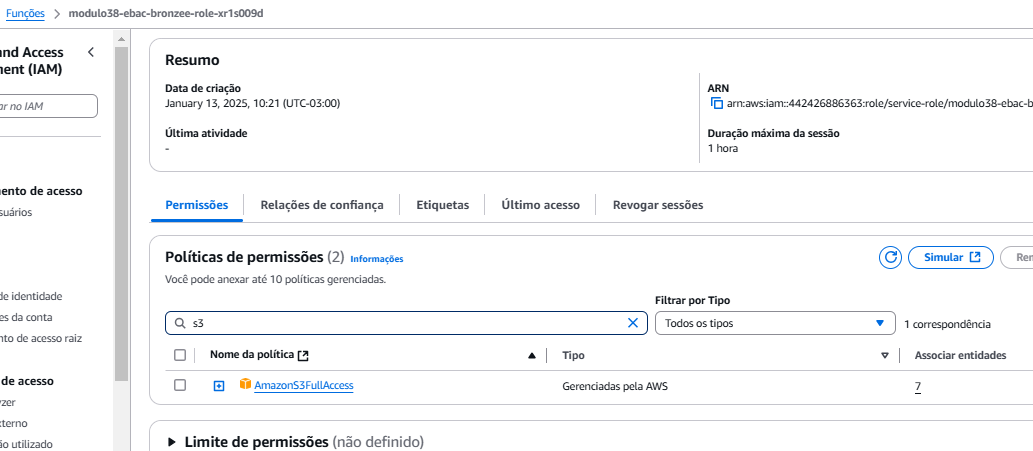

**Parte 5: Realizando teste de código:**

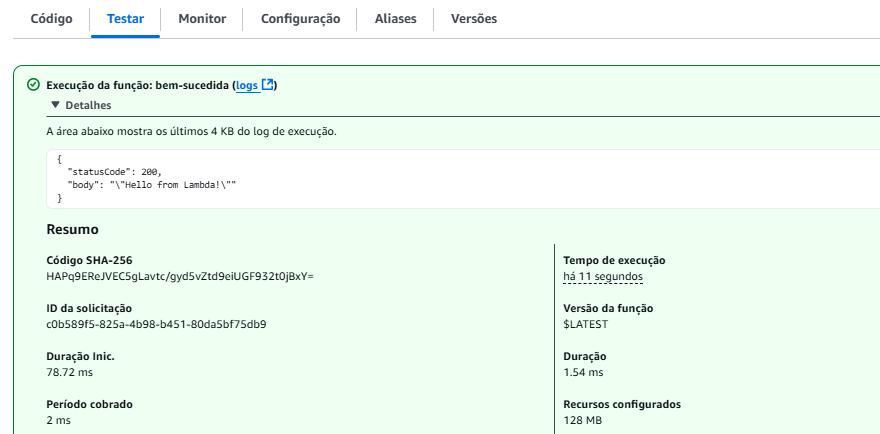

**Parte 6: Verificar Resultado de extração no Bucket s3 modulo38-ebac-bronze (Dado Original)**

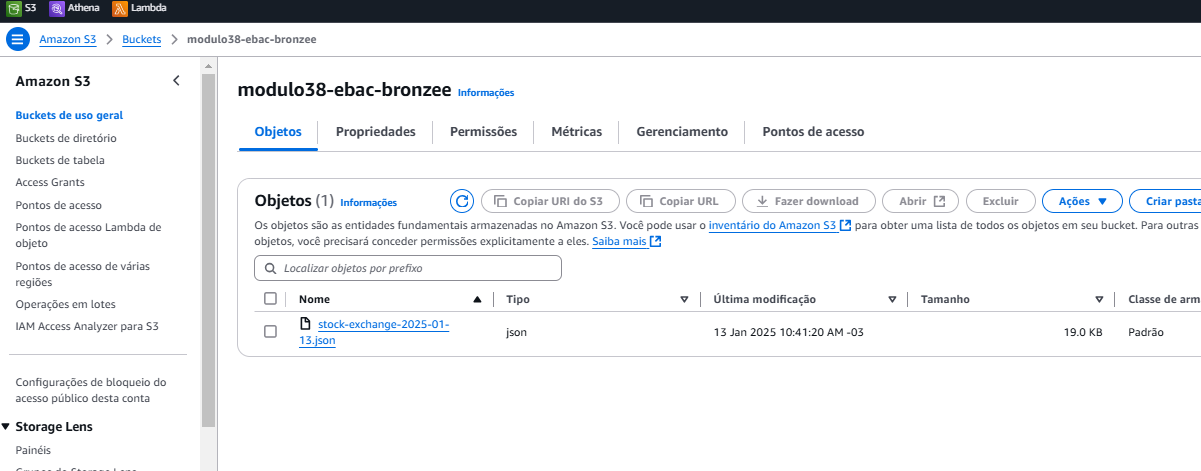

# **Criar um bucket no AWS S3 e Função no lambda para salvar o dado transformado (silver);**

**Bucket criado no S3:**

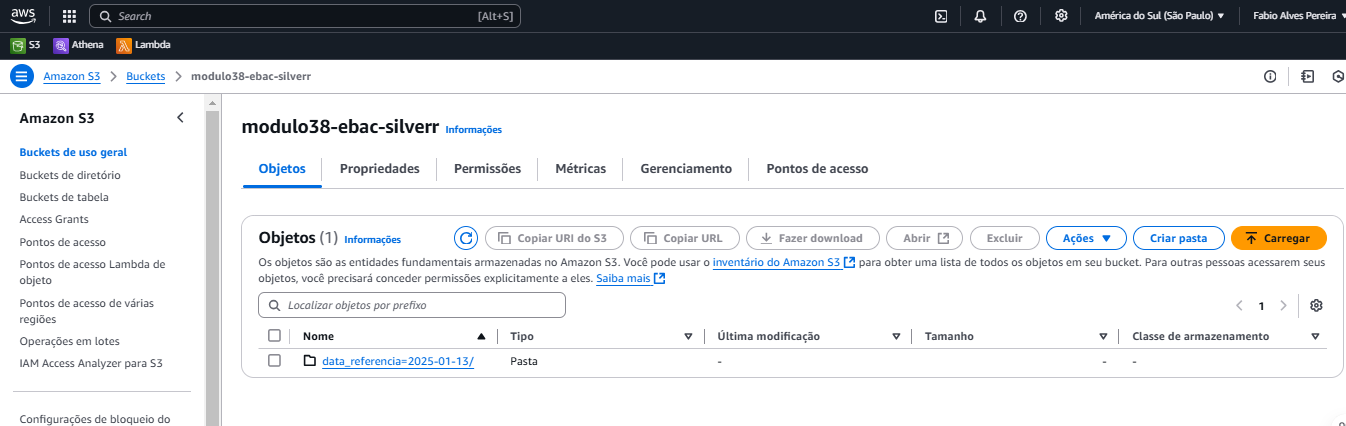


Código AWS [Lambda](https://aws.amazon.com/pt/lambda/) para *bucket* **silver**:

---



In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:
    # -- setup
    BRONZE_BUCKET = 'modulo38-ebac-bronzee'
    SILVER_BUCKET = 'modulo38-ebac-silverr'

    client = boto3.client('s3')

    date = datetime.now().strftime('%Y-%m-%d')
    filename_csv = f'stock-exchange-{date}.csv'
    filename_json = f'stock-exchange-{date}.json'

    # -- extract
    client.download_file(BRONZE_BUCKET, filename_json, f'/tmp/{filename_json}')

    with open(f"/tmp/{filename_json}", mode='r', encoding='utf8') as fp:
        data = json.load(fp)

    # -- transform
    transformed_data = []

    for record in data:
        transformed_record = {
            'taxa': record['valor'].replace(',', '.'),
            'dataTaxa': datetime.strptime(record['data'], '%d/%m/%Y').strftime('%Y-%m-%d'),
        }
        transformed_data.append(transformed_record)

    # -- load
    try:
        with open(f'/tmp/{filename_csv}', mode='w', encoding='utf8') as fp:
            fp.write('taxa,dataTaxa\n')
            for record in transformed_data:
                fp.write(f"{record['taxa']},{record['dataTaxa']}\n")
        client.upload_file(Filename=f'/tmp/{filename_csv}', Bucket=SILVER_BUCKET, Key=f'data_referencia={date}/{filename_csv}')
    except ClientError as exc:
        raise exc

    return json.dumps(dict(status=True))

**Imagem de inserção de código na função:**

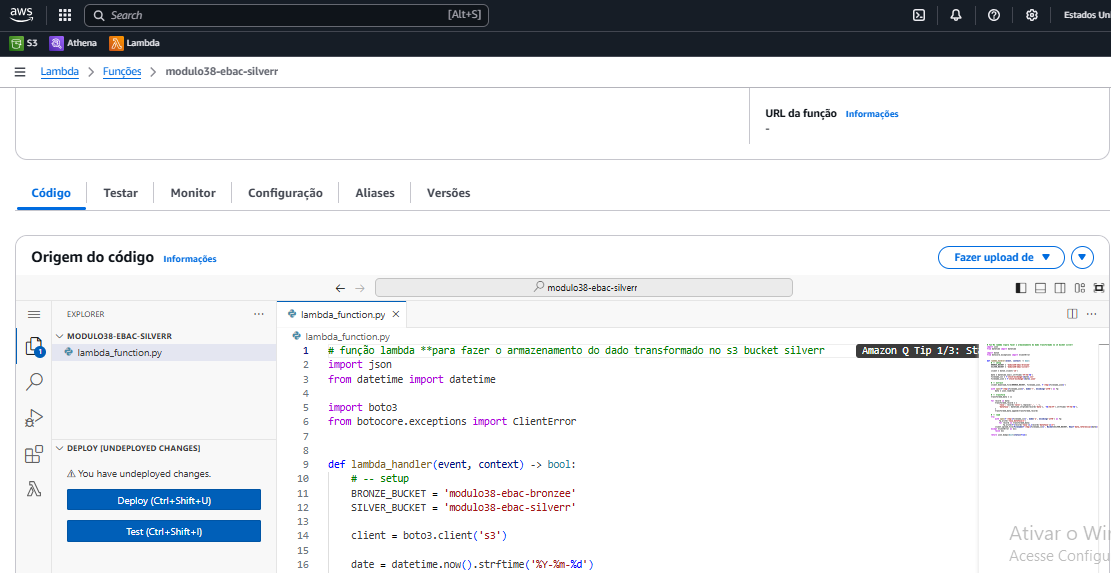

**Após validar permissões e testar devemos  verificar se obtevemos o resultado esperado no bucket s3 Silverr.**

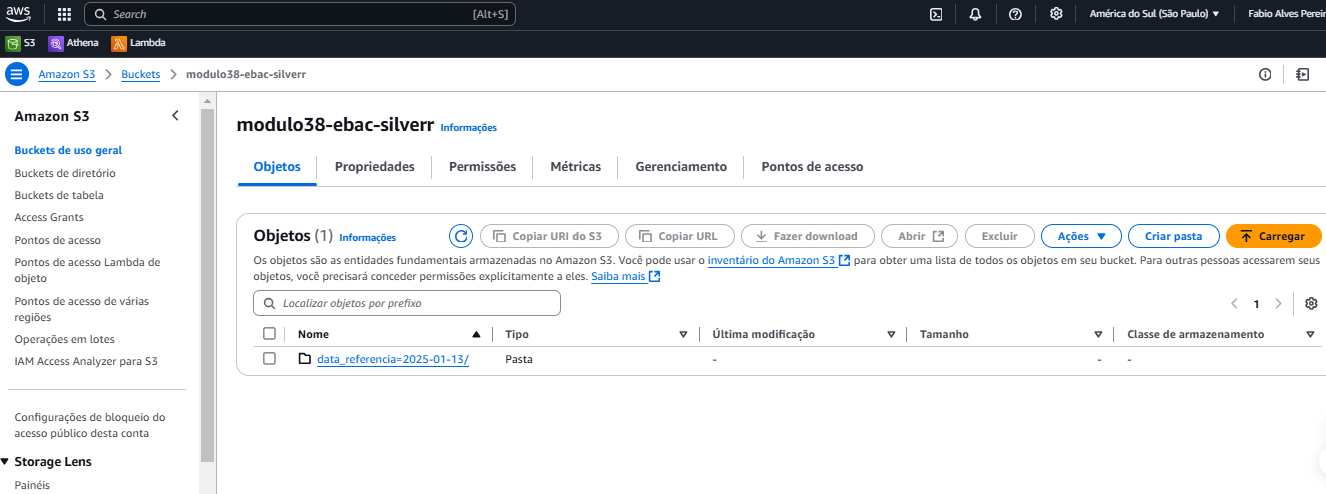

AWS [Lambda](https://aws.amazon.com/pt/lambda/) para **tabela:**

**Criação do bucket tabela resultados para manipular dados transformados:**

In [ ]:
import json
from datetime import datetime

import boto3
from botocore.exceptions import ClientError


def lambda_handler(event, context) -> bool:

  # -- setup

  SILVER_BUCKET = 'modulo38-ebac-silverr'

  query = f"""
  CREATE EXTERNAL TABLE IF NOT EXISTS cdi (
    taxa double,
    dataTaxa string
  )
  PARTITIONED BY (
    data_referencia string
  )
  ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
  WITH SERDEPROPERTIES ('separatorChar'=',')
  LOCATION 's3://{SILVER_BUCKET}/'
  """

  client = boto3.client('athena')

  # -- create

  try:
    client.start_query_execution(
      QueryString=query,
      ResultConfiguration={'OutputLocation': 's3://modulo38-tabela-results/'}
    )
  except ClientError as exc:
    raise exc

  # -- update

  try:
    client.start_query_execution(
      QueryString='MSCK REPAIR TABLE cdi',
      ResultConfiguration={'OutputLocation': 's3://modulo38-tabela-results/'}
    )
  except ClientError as exc:
    raise exc

  return json.dumps(dict(status=True))

**Imagem de inserção de código na função:**

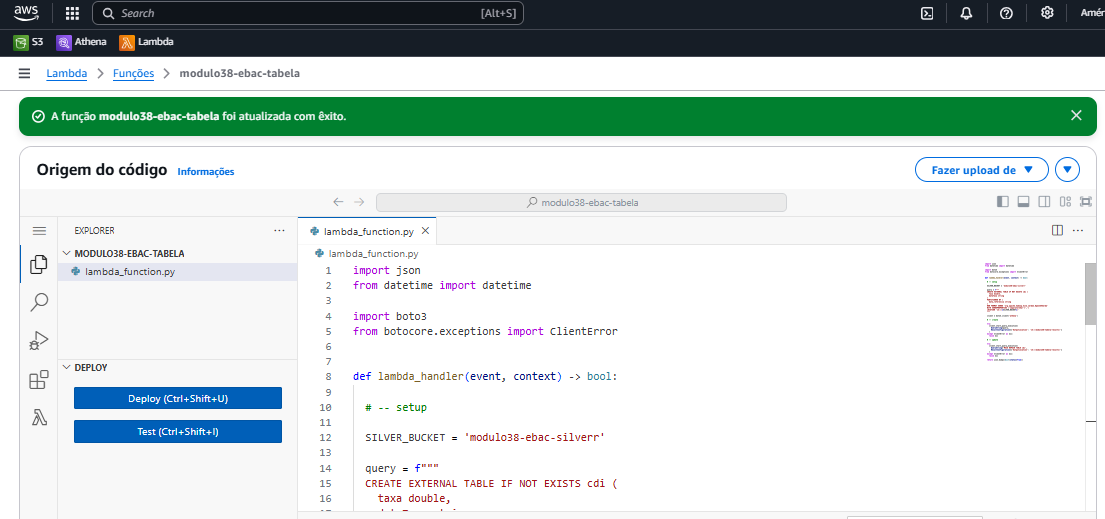

**Após validar permissões e testar devemos verificar se obtevemos o resultado esperado no Athena sendo criada tabela CDI.**

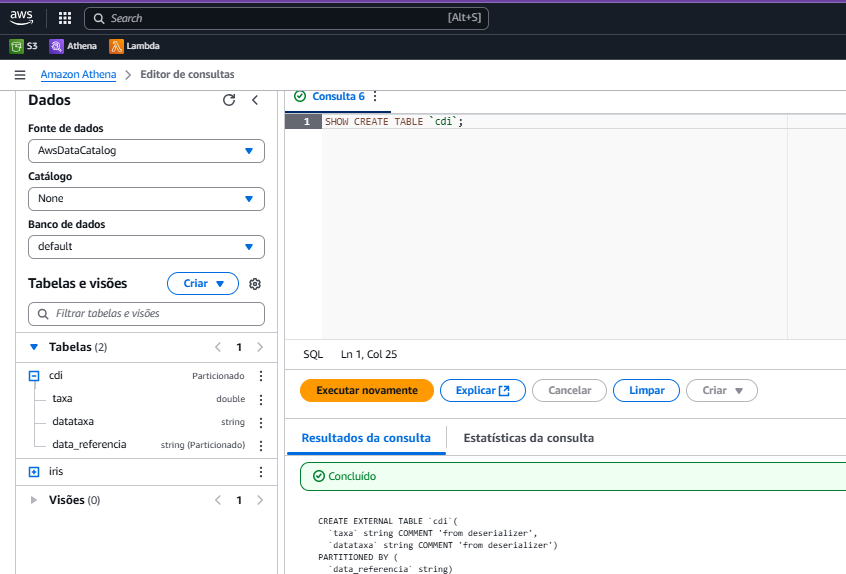

## 2\. AWS Step Functions

Replique as atividades do item 2.3 em sua conta.


**Criado o fluxo de execução:**

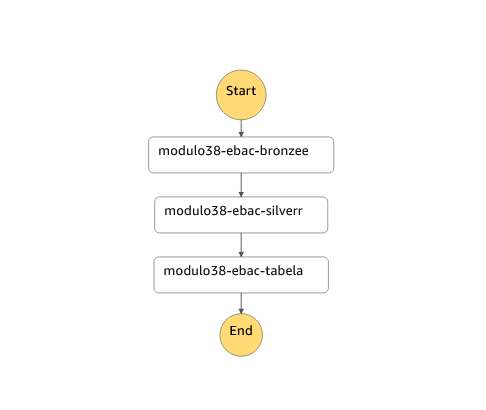

**Realizado o teste de execução para confirmar funcionamento:**

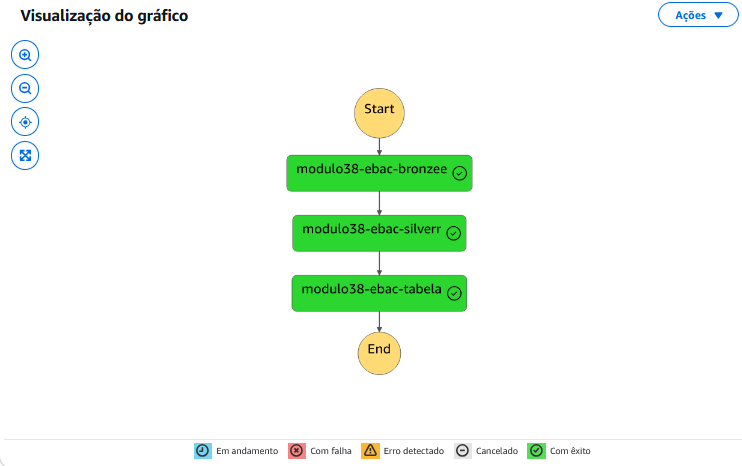

## 3\. AWS EventBridge

Replique as atividades do item 3.3 em sua conta.

**Criando um evento que inicie o state machine da tarefa 2.3:**

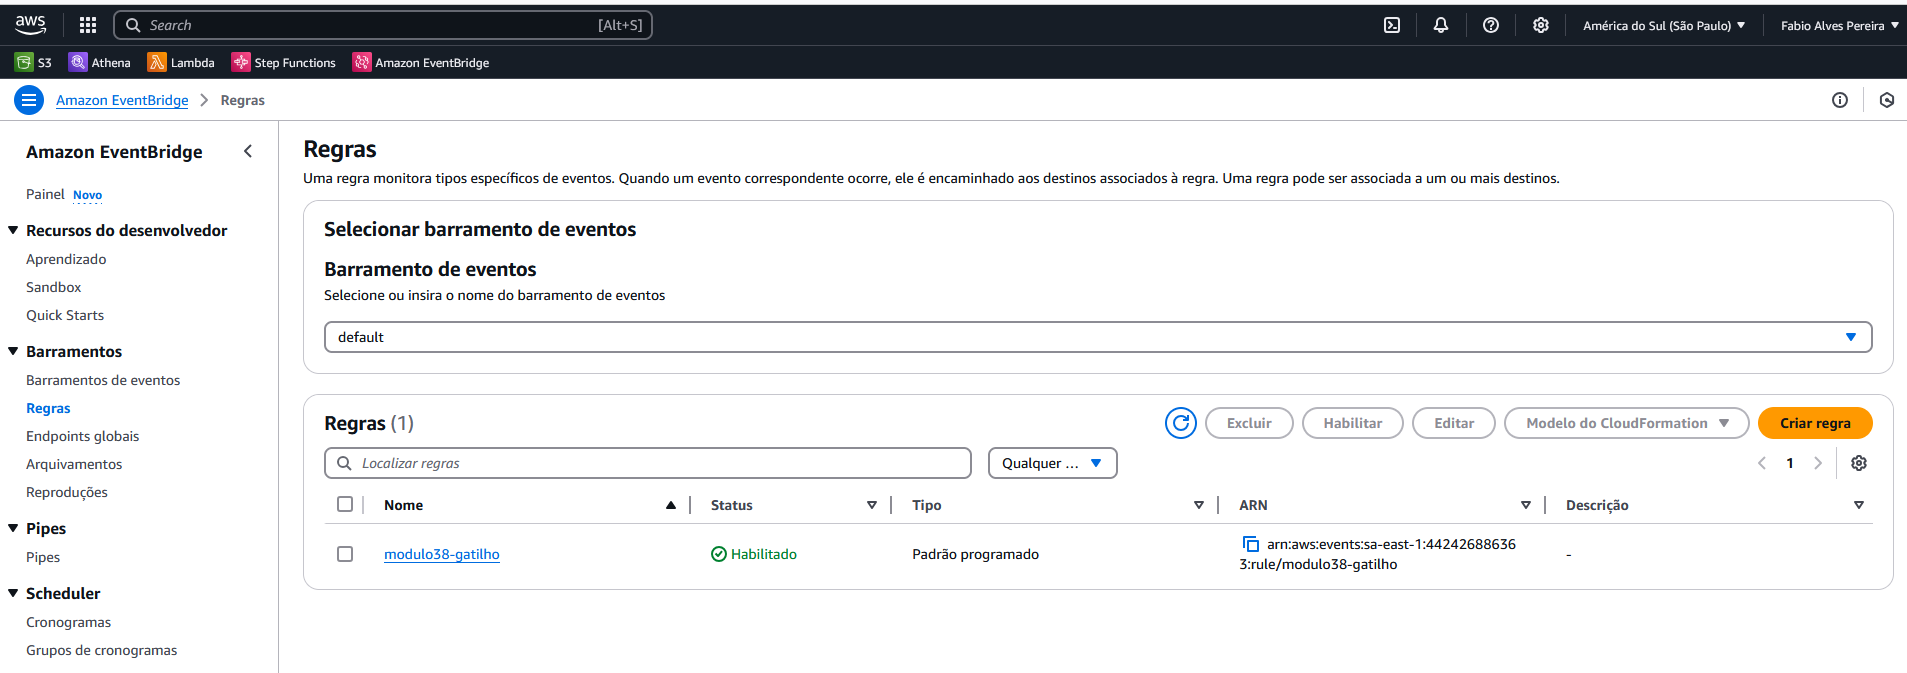